# Application of machine learning concepts on lung X-rays to indicate COVID-19

In this project we will build and train a neural network in Tensorflow. 
- more details
- Dataset: [Public X-rays on Github](https://github.com/ieee8023/covid-chestxray-dataset)
- Waterkant Dataset: [CAU cloud as zip](https://cloud.physik.uni-kiel.de/index.php/s/aLDok2nyDawrHnE)





#TO DO LIST
- Preprocess the images: Make them all purely grayscale (and mark them for potential problems) <font color="purple"> $\boxed{\checkmark}$ TD </font>
- Brightness augmentations <font color="green"> $\boxed{\checkmark}$ VD </font>
- Noise/Interference augmentations
- In-Process plots to monitor the learning and source data plots <font color="green"> $\boxed{\checkmark}$ VD </font>
- Data evaluation plots to spot possible overfitting or other issues <font color="green"> $\boxed{\checkmark}$ VD </font>
- Including a git-pull instead of resetting every time <font color="purple"> $\boxed{\checkmark}$ TD </font>
- Create automatic steps per epoch integer<font color="green"> $\boxed{\checkmark}$ VD </font>
- Add confusion matrix
<font color="blue"> $\boxed{\checkmark}$ KK </font>
- Add upload field for testing unclassified images from extern
<font color="blue"> $\boxed{\checkmark}$ KK </font>
- Add imread from 2 class source for KFStratified
<font color="blue"> $\boxed{\checkmark}$ KK </font>
- Add model.evaluation
- Add regular expressions to data management, to anticipate slightly misslabeled entries
- Include a pre-trained neural network VGG16, see http://www.robots.ox.ac.uk/~vgg/research/very_deep/<font color="green"> $\boxed{\checkmark}$ VD </font>
- Include more pre-trained NNs as alternative, e.g. ResNet50 from Keras https://engmrk.com/kerasapplication-pre-trained-model/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com <font color="purple"> $\boxed{\checkmark}$ TD </font>
- Additional Ideas

#Imports

In [0]:
#Basics
import os
import random
import shutil
import re
import numpy as np
import cv2
from tqdm import tqdm
from shutil import copyfile
from os import getcwd
import pandas as pd
import zipfile
import json
import math
from datetime import datetime

#Google
from google.colab import drive

#Neural Network related
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from keras.callbacks import EarlyStopping

#Pretrained Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model

#Displaying
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

#KF
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Connecting to the Google Drive


In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Downloading, implementing and redirecting input data into directory structure

Downloading

In [0]:
!curl -o D10.zip -L https://cloud.physik.uni-kiel.de/index.php/s/aLDok2nyDawrHnE/download
#Clean up directory

try:
    shutil.rmtree('/content/chest_xray')
    print("Base directory was successfully cleaned")
except OSError as error:
    print("Dont need to clean if there is nothing to clean")


#Entpacken
local_zip = '/content/D10.zip'
print(os.path.getsize(local_zip)) 

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/chest_xray')
zip_ref.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1179M  100 1179M    0     0  10.5M      0  0:01:51  0:01:51 --:--:-- 11.2M
Dont need to clean if there is nothing to clean
1237193393


Defining output directory variables fitting to the downloaded dataset and create them

In [0]:
base_inputdata_dir = '/content/chest_xray/chest_xray'

waterkant20_train         = base_inputdata_dir+'/train'  #training data in two groups
waterkant20_train_covid   = waterkant20_train+'/PNEUMONIA'    
waterkant20_train_nocovid = waterkant20_train+'/NORMAL'

waterkant20_val           = base_inputdata_dir+'/val'    #validation data during training in two groups
waterkant20_val_covid     = waterkant20_val+'/PNEUMONIA'
waterkant20_val_nocovid   = waterkant20_val+'/NORMAL'

waterkant20_test  = base_inputdata_dir+'/test'           #final mixed test data not cliassified so far
waterkant20_test_mix = waterkant20_test+'/MIX'           # <=== Let's sort it!!!

#Checking contents
waterkant20_path_list=[waterkant20_train_covid,waterkant20_val_covid,waterkant20_train_nocovid,waterkant20_val_nocovid,waterkant20_test_mix]

for path in waterkant20_path_list:
  print(str(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))+" files in "+path)

3875 files in /content/chest_xray/chest_xray/train/PNEUMONIA
8 files in /content/chest_xray/chest_xray/val/PNEUMONIA
1341 files in /content/chest_xray/chest_xray/train/NORMAL
8 files in /content/chest_xray/chest_xray/val/NORMAL
624 files in /content/chest_xray/chest_xray/test/MIX


#Creating directories

In [0]:
#Cleanup
try:
    shutil.rmtree('/content/gdrive/My Drive/Deep_Learning_Project/Data')
    print("Base directory was successfully cleaned")
except OSError as error:
    print("Dont need to clean if there is nothing to clean")


#Base directory for monochromized files before feeding to Training/Testing and Prediction
base_dir             = '/content/gdrive/My Drive/Deep_Learning_Project/Data'

training_dir         = os.path.join(base_dir, 'training')
training_covid_dir   = os.path.join(training_dir, 'covid')
training_nocovid_dir = os.path.join(training_dir, 'nocovid')

testing_dir          = os.path.join(base_dir, 'testing')
testing_covid_dir    = os.path.join(testing_dir, 'covid')
testing_nocovid_dir  = os.path.join(testing_dir, 'nocovid')

prediction_dir   = os.path.join(base_dir, 'prediction') #First unlabeled datset for prediction
prediction_dir_2 = os.path.join(base_dir, 'prediction2') #Second unlabeled datset for prediction

#Not needed for Waterkant dataset - final cleanup will sort this | VD
#source_covid = os.path.join(base_dir, 'source_covid')
#source_nocovid = os.path.join(base_dir, 'source_nocovid')

dir_list = [training_covid_dir, training_nocovid_dir, testing_covid_dir, testing_nocovid_dir, prediction_dir] #source_covid, source_nocovid 

for entry in dir_list:
    try: 
        os.makedirs(entry, exist_ok = True) 
        print("Directory '%s' was created successfully" %entry) 
    except OSError as error: 
        print("Directory '%s' can not be created" %entry) 

Dont need to clean if there is nothing to clean
Directory '/content/gdrive/My Drive/Deep_Learning_Project/Data/training/covid' was created successfully
Directory '/content/gdrive/My Drive/Deep_Learning_Project/Data/training/nocovid' was created successfully
Directory '/content/gdrive/My Drive/Deep_Learning_Project/Data/testing/covid' was created successfully
Directory '/content/gdrive/My Drive/Deep_Learning_Project/Data/testing/nocovid' was created successfully
Directory '/content/gdrive/My Drive/Deep_Learning_Project/Data/prediction' was created successfully


# Monochromize and distribute data to the corresponding directories

The function monochromize(img) can monochromize (numpy)images. 
The function copyFileMonochromized uses monochromize() and in addition the output filename is expanded by keywords to reflect, if their input image:
*   did not have a dpi setting
*   did actually have color, expressed as with mean and max "color"-values

Some aspects could have been reflected by the .convert("L") function of 





In [0]:
#TD: monochromize the data! Using numpy slice operations: https://www.w3schools.com/python/numpy_array_slicing.asp
#TD: Using e ITU-R 601-2 luma transform: L = R * 299/1000 + G * 587/1000 + B * 114/1000, it does not affect already grayscale images saved as RGB...

#Reduces RGB and RGBA to monochrome numpy array
def monochromize(img): 
  if (img.ndim==2): 
    return img                                      #monochrome
  if (img.ndim==3):
    channels = img.shape[2]
    if (channels==3):
      return (img[:,:,0]*0.299+img[:,:,1]*0.587+img[:,:,2]*0.114).astype(int) #RGB
    if (channels==4):
      return (img[:,:,0]*0.299+img[:,:,1]*0.587+img[:,:,2]*0.114).astype(int) #RGBA - no usage of alpha channel
  print("image is neither of type monochrome,RGB or RGBA. Contact the dataset provider.")
  return img                                   


#TD: Apply monochromize while copying the file from path_in to path_out
def copyfileMonochromized(img_path_in,img_path_out):
    im = Image.open(img_path_in,mode="r")
    img = np.asarray(im)
    
    #Additional info endings to file
    t = ".tif"
    m = "_monochromized"

    #check for color!
    c = ""
    if (img.ndim==3): #not monochrome
        if not (np.count_nonzero(img[:,:,0]-img[:,:,1])==0 and np.count_nonzero(img[:,:,0]-img[:,:,2])==0 and np.count_nonzero(img[:,:,1]-img[:,:,2])==0):
            mean = int(round((np.average(np.abs(img[:,:,0].astype(int)-img[:,:,1])) + np.average(np.abs(img[:,:,0].astype(int)-img[:,:,2])) + np.average(np.abs(img[:,:,1].astype(int)-img[:,:,2])))/3.0))
            maxi = np.amax([np.amax(np.abs(img[:,:,0].astype(int)-img[:,:,1])),np.amax(np.abs(img[:,:,0].astype(int)-img[:,:,2])),np.amax(np.abs(img[:,:,1].astype(int)-img[:,:,2]))])
            c = "_hadcolor_"+str(mean)+"_"+str(maxi)

    d = "_nodpi"
    img = monochromize(img)
    im2 = Image.fromarray(np.uint8(img))
    dpi = im.info.get('dpi')
    if dpi is None: #no dpi setting
        im2.save(img_path_out+c+d+m+t)
    else:
      dpi_x,dpi_y = dpi
      im2.save(img_path_out+c+m+t,resolution_unit="inch", x_resolution=dpi_x, y_resolution=dpi_y)

Copy dataset into corresponding directories while monochromizing the data

In [0]:
# Tuple list of directories with [source, destination] layout
waterkant20_src_dest_list=[[waterkant20_train_covid,training_covid_dir],
                           [waterkant20_val_covid,testing_covid_dir],
                           [waterkant20_train_nocovid,training_nocovid_dir],
                           [waterkant20_val_nocovid,testing_nocovid_dir],
                           [waterkant20_test_mix,prediction_dir]]

                           #[waterkand20_train_covid,source_covid],[waterkand20_val_covid,source_covid],
                           #[waterkand20_train_nocovid,source_nocovid],[waterkand20_val_nocovid,source_nocovid]]

                           
for src,dest in waterkant20_src_dest_list:
  print("Copy "+src+" to "+dest)
  src_files = os.listdir(src)
  for file_name in src_files:
    full_file_src = os.path.join(src, file_name)
    full_file_dest = os.path.join(dest,file_name)
    if os.path.isfile(full_file_src):
        #shutil.copy(full_file_name, dest)
        copyfileMonochromized(full_file_src,full_file_dest)

Copy /content/chest_xray/chest_xray/train/PNEUMONIA to /content/gdrive/My Drive/Deep_Learning_Project/Data/training/covid
Copy /content/chest_xray/chest_xray/val/PNEUMONIA to /content/gdrive/My Drive/Deep_Learning_Project/Data/testing/covid
Copy /content/chest_xray/chest_xray/train/NORMAL to /content/gdrive/My Drive/Deep_Learning_Project/Data/training/nocovid
Copy /content/chest_xray/chest_xray/val/NORMAL to /content/gdrive/My Drive/Deep_Learning_Project/Data/testing/nocovid
Copy /content/chest_xray/chest_xray/test/MIX to /content/gdrive/My Drive/Deep_Learning_Project/Data/prediction


In [0]:
#Checking contents after copying
waterkant20_path_list2=[training_covid_dir,testing_covid_dir,training_nocovid_dir,testing_nocovid_dir,prediction_dir]

for path in waterkant20_path_list2:
  print(str(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))+" files in "+path)

3875 files in /content/gdrive/My Drive/Deep_Learning_Project/Data/training/covid
8 files in /content/gdrive/My Drive/Deep_Learning_Project/Data/testing/covid
1341 files in /content/gdrive/My Drive/Deep_Learning_Project/Data/training/nocovid
8 files in /content/gdrive/My Drive/Deep_Learning_Project/Data/testing/nocovid
624 files in /content/gdrive/My Drive/Deep_Learning_Project/Data/prediction


#Add some augmentations to generate additional training data

In [0]:
#Setting up the generators and creating and instance of it
#Hyperparameters
batch_size_training = 32
batch_size_testing = 4


training_datagen = ImageDataGenerator(rescale=1.0/255,
                                      rotation_range=10,
                                      zoom_range=0.1,
                                      brightness_range=[0.7,1.3],
                                      horizontal_flip=True,
                                      #vertical_flip=True,  #Not happening in our data
                                      fill_mode='nearest'
                                      )

testing_datagen = ImageDataGenerator(rescale = 1.0/255.)


training_generator = training_datagen.flow_from_directory(training_dir,
                                                         batch_size=batch_size_training,
                                                         class_mode  = 'binary',
                                                         target_size = (324, 324))

testing_generator = testing_datagen.flow_from_directory(testing_dir,
                                                    batch_size=batch_size_testing,
                                                    class_mode='binary',
                                                    target_size=(324, 324))


#Expected output training:   5216, 2 classes
#Expected output validation: 16,   2 classes 

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#Creating the Neural network 
- Based on pretrained model(VGG16)
- Exit at block3_pool layer of the VGG16 to keep a certain minimum shape to still work with

- A not pretrained model can be found in the Appendix


In [0]:
#Create an instance of the pretrained model

#Setting up some Hyperparameters
pre_trained_setup = "VGG16" #"ResNet50"  #Hyperparameter to change bewteen the pretrained models
lr = 0.0015 # Learning rate # Adjusted by VD on 3.6.2020
dr_0 = 0.65 # Dropout rate for first layer it appears in
dr_1 = 0.6 # Dropout rate for second layer it appears in

if (pre_trained_setup == "VGG16"):
    print("Using VGG16")
    pre_trained_model = VGG16(input_shape = (324, 324, 3), 
                              include_top = False, 
                              weights = "imagenet") # We can consider other weights too! VD see http://www.robots.ox.ac.uk/~vgg/research/very_deep/
if (pre_trained_setup == "ResNet50"):
    print("Using ResNet50")
    pre_trained_model = ResNet50(input_shape = (324, 324, 3), 
                                 include_top = False, 
                                 weights = "imagenet")


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  
 # Print the model summary if you want further infos
 # print(pre_trained_model.summary())

#TD selectiong between VGG16 and ResNet50
#Choosing a "exit"-layer from the pretrained to further use the selfmodeled one
if (pre_trained_setup == "VGG16"):
  #last_layer = pre_trained_model.get_layer('block3_pool') # 40, 40, 256 =>  40, 40, 512
  last_layer = pre_trained_model.get_layer('block2_pool') # 80, 80
  #last_layer = pre_trained_model.get_layer('block4_pool') # 40, 40
if (pre_trained_setup == "ResNet50"):
  last_layer = pre_trained_model.get_layer('conv3_block2_add') # 41, 41, 512 => 41, 41, 512
last_output = last_layer.output



# Add costum layers after the pretrained model for specific purposes
output = layers.Conv2D(32, (3,3), activation='relu')(last_output)
output = layers.AveragePooling2D(2,2)(output)
output = layers.Conv2D(64, (3,3), activation='relu')(output)
output = layers.MaxPooling2D(2,2)(output)
output = layers.Dropout(dr_0)(output)
output = layers.Conv2D(128, (3,3), activation='relu')(output)
output = layers.MaxPooling2D(2,2)(output)
output = layers.Flatten()(output) 
output = layers.Dense(512, activation='relu')(output)
output = layers.Dropout(dr_1)(output) 
output = layers.Dense(1, activation='sigmoid')(output) 

# Create a instance of the model in the desired layout
model = Model( pre_trained_model.input, output)   

#Compile it!
model.compile(optimizer = Adam(learning_rate=lr), 
              loss = 'binary_crossentropy',
              metrics = ['acc'])

#Setup a Callback to not overcomputate
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience = 3, monitor = "acc", mode="max", verbose = 1)


Using VGG16


#Run the model and test it

In [0]:
#Hyperparameter
epochs = 2



history = model.fit_generator(training_generator,
                              epochs=epochs,
                              steps_per_epoch=int((len(os.listdir(training_covid_dir))+len(os.listdir(training_nocovid_dir)))/batch_size_training),
                              validation_data=testing_generator,
                              verbose = 1,
                              validation_steps=int((len(os.listdir(testing_covid_dir))+len(os.listdir(testing_nocovid_dir)))/batch_size_testing),
                              callbacks=[early_stopping_monitor])

Epoch 1/2
163/163 [==============================] - 1648s 10s/step - loss: 1.2008 - acc: 0.7349 - val_loss: 0.8115 - val_acc: 0.5000
Epoch 2/2
163/163 [==============================] - 718s 4s/step - loss: 0.4249 - acc: 0.7669 - val_loss: 0.4496 - val_acc: 0.8125


# Run the model on evaluation set for Waterkant and print it into the desired .json file

In [0]:
#
waterkant_prediction_list = os.listdir(prediction_dir_2)
nrlab = []
low=0;
hi=0;

for filename in waterkant_prediction_list:
  # predicting images
  path = prediction_dir_2 + '/' + filename
  img=image.load_img(path, target_size=(324, 324))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=100)

  nr = (re.match(r"^([^.]*)\..*$",filename)).group(1)
  lab = classes[0]
  c = int(round(lab[0]))
  nrlab.append([int(nr),c]) #TD sigmoid from -inf..inf spans 0..1, cut at 0.5

#  print(lab)
  if c == 1:
    hi += 1
#    print(filename + " is not covid")
  else:
    low +=1
#    print(filename + " is covid")


print("Distribution: "+str(hi)+" High and "+str(low)

#nrlab.sort(key=lambda tup: tup[0])
L = ["[\n"]  
for n,l in nrlab:
  L.append('  {"image": "'+str(n)+'.jpg", "prediction": '+str(l)+'},\n')
L[len(L)-1] = L[len(L)-1][:-2]+"\n"
L.append("]\n")
file1 = open('covid-'+datetime.now().strftime('%Y%m%d%H%M%S')+'.json',"w")
file1.writelines(L)
file1.close()

624 Test: 105 High and 71 Low! Best = 50.96%


In [0]:
prediction_dir_2 = os.path.join(base_dir, 'prediction2')

dir_list =[prediction_dir_2]

for entry in dir_list:
    try: 
        os.makedirs(entry, exist_ok = True) 
        print("Directory '%s' was created successfully" %entry) 
    except OSError as error: 
        print("Directory '%s' can not be created" %entry) 

!curl -o D10.zip -L https://cloud.physik.uni-kiel.de/index.php/s/mAYD278NrifpkQo/download

local_zip = '/content/D10.zip'
print(os.path.getsize(local_zip)) 

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/chest_xray/MIX')
zip_ref.close()



Directory '/content/gdrive/My Drive/Deep_Learning_Project/Data/prediction2' was created successfully
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  3990k      0  0:00:06  0:00:06 --:--:-- 6249k
26374041


In [0]:
# Tuple list of directories with [source, destination] layout
waterkant20_test_mix_2 = '/content/chest_xray/MIX'

waterkant20_src_dest_list=[
                           [waterkant20_test_mix_2,prediction_dir_2]]

                           #[waterkand20_train_covid,source_covid],[waterkand20_val_covid,source_covid],
                           #[waterkand20_train_nocovid,source_nocovid],[waterkand20_val_nocovid,source_nocovid]]

                           
for src,dest in waterkant20_src_dest_list:
  print("Copy "+src+" to "+dest)
  src_files = os.listdir(src)
  for file_name in src_files:
    full_file_src = os.path.join(src, file_name)
    full_file_dest = os.path.join(dest,file_name)
    if os.path.isfile(full_file_src):
        #shutil.copy(full_file_name, dest)
        copyfileMonochromized(full_file_src,full_file_dest)

Copy /content/chest_xray/MIX to /content/gdrive/My Drive/Deep_Learning_Project/Data/prediction2


# KFStratified wrap around CNN

In [0]:
## KK imread from 2 class source for KFStratified

CATEGORIES = ["source_covid", "source_nocovid"]

IMG_SIZE = 324




training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(base_dir,category)  # create path to covid noncovid
        class_num = CATEGORIES.index(category)  # get the classification 0 or 1

        for img in tqdm(os.listdir(path)):  # iterate over each image covid noncovid
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:
                pass

create_training_data()
print(len(training_data))

# shuffle the sorted readed images from folder ...00000... , ...11111...
random.shuffle(training_data)

#TD try numpy instead of = []
#IMAGES = np.array() #image
#LABELS = np.array() #label
# split in X and y
#for features,label in training_data:
#    np.append(IMAGES,features)
#    np.append(LABELS,label)

#TD try numpy instead
IMAGES = [] #image
LABELS = [] #label
# split in X and y
for features,label in training_data:
    IMAGES.append(features)
    LABELS.append(label)




# reshape for cnn
IMAGES = np.array(IMAGES).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #1=grayscale
LABELS = np.array(LABELS)

# normalize data between 0 and 1
IMAGES = IMAGES/255.0
np.shape(IMAGES)

100%|██████████| 1349/1349 [01:28<00:00, 15.20it/s]


5232


(5232, 324, 324, 1)

In [0]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from sklearn.utils import shuffle


#TEST ARRAYS
XX = [(22,22),(333,333),(55,55),(44,44),(666,666),(88,666),(889,666),(9,666),(9000,666)]
yy = [0,0,0,0,1,1,1,0,2]

XX = np.array(XX)
yy = np.array(yy)




# function confusion matrix
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual / True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)



# function for set up all classes to equal
def balance2D_minority_class(x_in, y_in):
    #org_shape = x_in.shape
    #vol_shape = x_in.shape[1:]
    #n_voxels = np.prod(vol_shape)
     
    #images_by_voxel = x_in.reshape((x_in.shape[0], n_voxels), order='C')
    
    ros = RandomOverSampler(sampling_strategy='not majority', random_state=12, return_indices=True)
    x_in, y_in, idx = ros.fit_sample(x_in, y_in)#(images_by_voxel, y_in)
    print('Oversample indexes:', idx)

    x_in, y_in = shuffle(x_in, y_in, random_state=12)
    
    #x_in = x_in.reshape(x_in.shape[0], *vol_shape)
      
    return x_in, y_in


# things for SKF
N_SPLITS = 3

# things for CNN
EPOCHS = 400
STEP_PER_EPOCH = 120
BATCH_SIZE = 3#5

# clear model in memory
model = None

# set crossvalidation iterator
SKF = StratifiedKFold(n_splits = N_SPLITS, shuffle=True, random_state=12)

for index_fold, (train_index, test_index) in enumerate(SKF.split(XX, yy)):
    print(train_index)
    print(test_index)
    print('\n--------NEW RUN---------\n')
   
    RUN = "training on fold " + str(index_fold+1) + "-" + str(N_SPLITS)
    print (RUN, '\n')
    #break
    # get the indeces
    
    print(IMAGES[0].shape)
    
    X_train, X_test, y_train, y_test = XX[train_index], XX[test_index], yy[train_index], yy[test_index]
    
    print('KFold_Train: ', y_train, '\nKFold_Test: ', y_test, '\n')
    
    # reshape, balancing by resampling minority classes reshape, shuffle
    X_train, y_train = balance2D_minority_class(X_train, y_train)
    print('Balance_shuffle_train: ', y_train, '\nTest: ', y_test, '\n')

    break

    # skf.split cant handle 1hot-encoding ... but we need it for cnn
    y_train = np.array(to_categorical(y_train), dtype='uint8')
    y_test = np.array(to_categorical(y_test), dtype='uint8')
    
    #-----------------------------------------------------------------------------------
    
    look_X_train.append(X_train)
    look_X_test.append(X_test)
    look_y_train.append(y_train)
    #look_y_test.append(y_test)
       
    datagen.fit(X_train)
    
    # clear model
    model = None

    # SET THE MODEL HERE in code or pick the define model 
    #model = cnn1(input_shape)

      
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer = Adam(lr=0.001),
                  metrics=['accuracy'])
    
    
    # fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                  steps_per_epoch=STEP_PER_EPOCH,
                                  epochs=EPOCHS,
                                  verbose=2)
    
    # prediction
    pred_class = model.predict(X_test)
    y_predict_class = np.argmax(pred_class, axis=1)
    
    #save predictions on y_test
    look_y_pred.append(y_predict_class)
    
    # redo 1-hot-encoding
    y_test_redo_1hot = [np.where(r==1)[0][0] for r in y_test]
    
    # save y_test classes
    look_y_test.append(y_test_redo_1hot)
    
    # get values outside this loop for global confusion matrix / statistics
    n_splits_scores.append(accuracy_score(y_test_redo_1hot, y_predict_class))
    n_splits_y_test = np.concatenate((n_splits_y_test, y_test_redo_1hot))
    n_splits_y_pred = np.concatenate((n_splits_y_pred, y_predict_class))


    # ready to plot
    #plot_cm(y_true, y_pred)
    

[2 3 4 6 7 8]
[0 1 5]

--------NEW RUN---------

training on fold 1-3 

(324, 324, 1)
KFold_Train:  [0 0 1 1 0 2] 
KFold_Test:  [0 0 1] 

Oversample indexes: [0 1 2 3 4 5 3 5 5]
Balance_shuffle_train:  [2 2 0 0 1 1 0 2 1] 
Test:  [0 0 1] 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
TD1 = np.array([1,2,3,44,5,6,7])
INDEX1 = np.array([3,4,5])
print(TD1[INDEX1])

print(np.append(TD1,3))

[44  5  6]
[ 1  2  3 44  5  6  7  3]


# prediction / evaluation (confusion matrix)

Instructions for updating:
Please use Model.predict, which supports generators.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


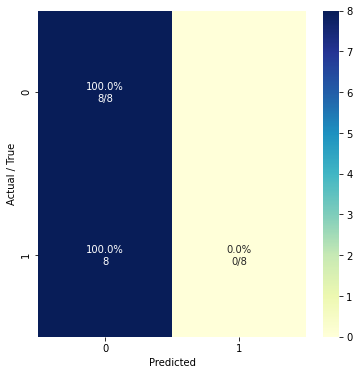

In [0]:
## KK

# get prediction from testing_generator with testdata length
predict = model.predict_generator(testing_generator, steps=len(testing_dir))
#print(predict)

#Y_pred = predict > 0.5
#print(Y_pred)

y_pred = np.argmax(predict, axis=1)
print(y_pred)

# get true class value from testdata
y_true = testing_generator.classes
#print(y_true)


# function confusion matrix
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual / True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# ready to plot
plot_cm(y_true, y_pred)

#confusion_matrix(y_true, y_pred)

# Load image from extern to run trough CNN


In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(324, 324))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " Covid_19")
  else:
    print(fn + " NO Covid-19") 

Using TensorFlow backend.


# Loading plot library and displaying some images from our dataset

<Figure size 1152x1152 with 0 Axes>

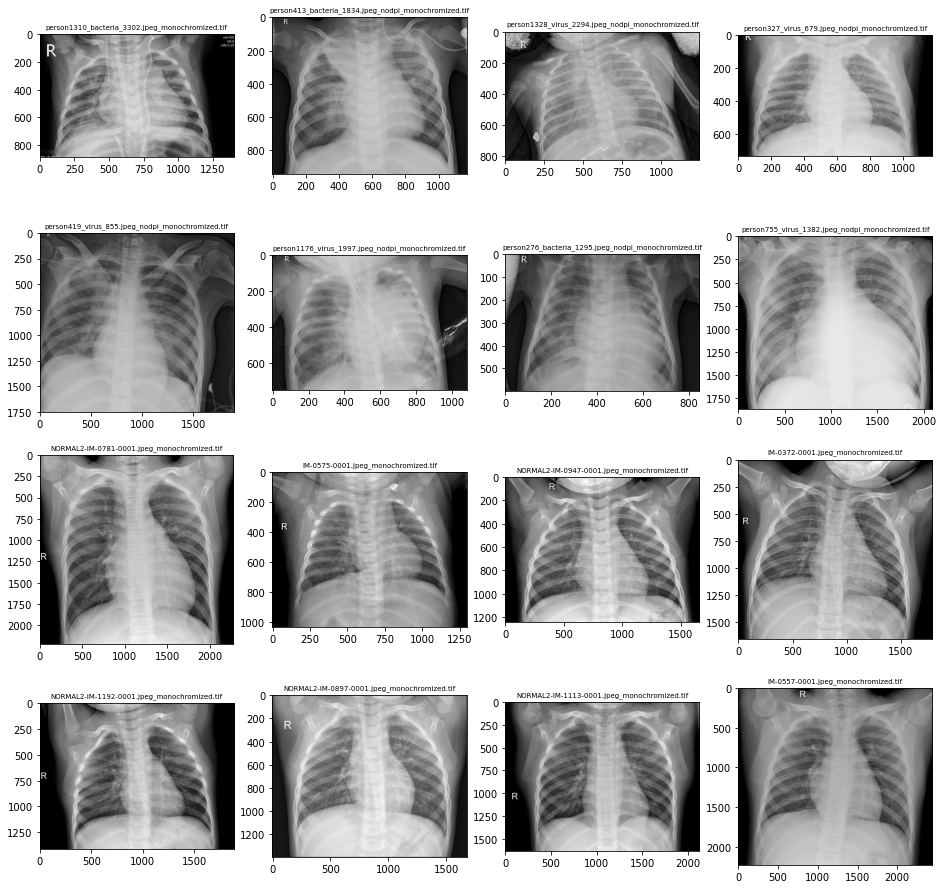

In [0]:
## KK imports nach oben verlagert

#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

# Grid parameters for display
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

#Create a list with the filenames for the iteration
training_covid_names = os.listdir(training_covid_dir)
training_nocovid_names = os.listdir(training_nocovid_dir)


# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_covid_pix = [os.path.join(training_covid_dir, fname) 
                for fname in training_covid_names[pic_index-8:pic_index]]
next_nocovid_pix = [os.path.join(training_nocovid_dir, fname) 
                for fname in training_nocovid_names[pic_index-8:pic_index]]


#TD now with filenames in the headlines...
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for ax,img_path in zip(axs.flat,next_covid_pix+next_nocovid_pix):
    fname = re.sub('^.*[\/\\\\]','',img_path)
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(str(fname),fontsize=7)
plt.show()

#for i, img_path in enumerate(next_covid_pix+next_nocovid_pix):
#  # Set up subplot; subplot indices start at 1
#  sp = plt.subplot(nrows, ncols, i + 1)
#  #sp.axis('Off') # Don't show axes (or gridlines)
#
#  img = mpimg.imread(img_path)
#TD: Set ",cmap="gray" " here (refer to https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) but also preprocess the incoming data in monochromize()
#  plt.imshow(img,cmap="gray")
#
#plt.show()



#Display intermediate steps to see the model working

Random file: /content/gdrive/My Drive/Deep_Learning_Project/Data/training/covid/person947_bacteria_2872.jpeg_nodpi_monochromized.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


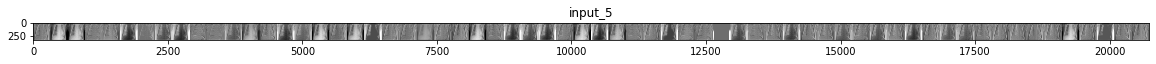

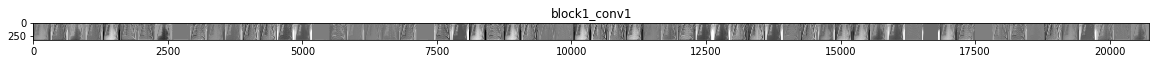

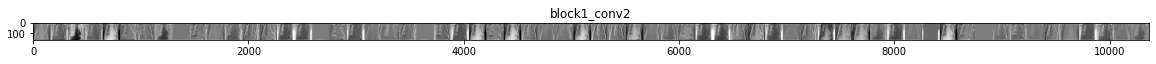

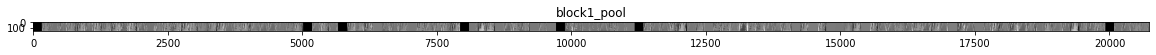

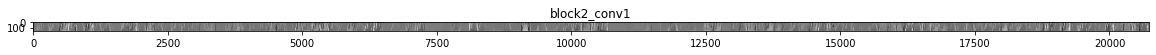

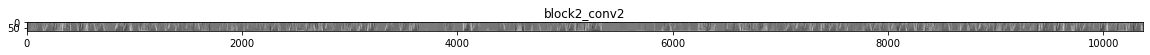

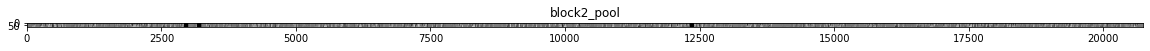

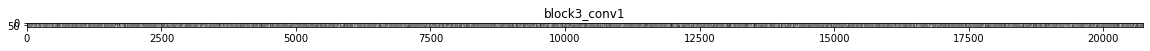

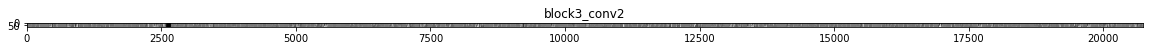

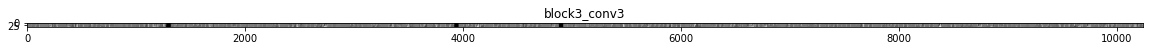

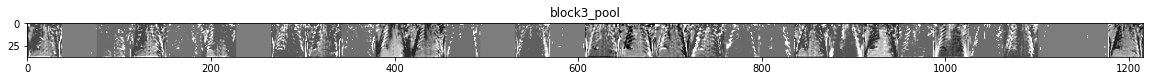

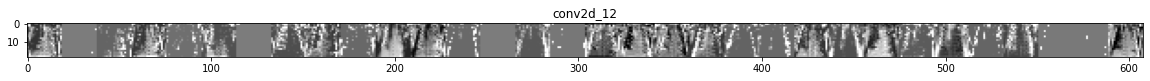

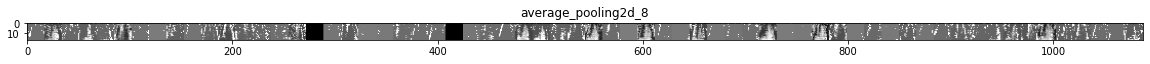

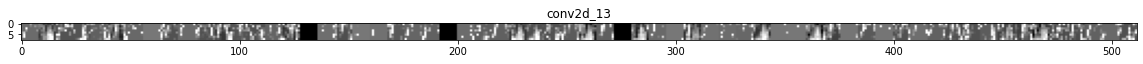

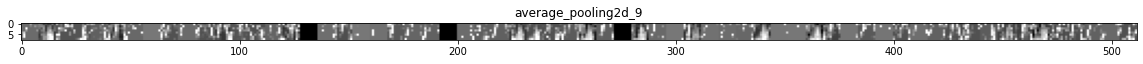

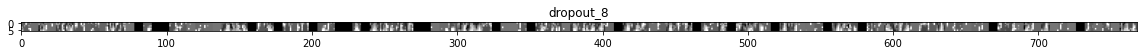

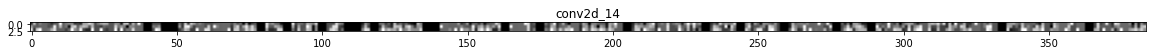

In [0]:
# This will take an image as input, and will output
# intermediate representations for all layers in the given model

training_covid_names = os.listdir(training_covid_dir)
training_nocovid_names = os.listdir(training_nocovid_dir)

successive_outputs = [layer.output for layer in model.layers[1:]]


#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


# Let's prepare a random input image from the training set.
covid_img_files = [os.path.join(training_covid_dir, f) for f in training_covid_names]
nocovid_img_files = [os.path.join(training_nocovid_dir, f) for f in training_nocovid_names]
img_path = random.choice(covid_img_files + nocovid_img_files)
#TD: Which one?
print("Random file: "+img_path)

img = load_img(img_path, target_size=(324, 324))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (324, 324, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 324, 324, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
#TD: Set ",cmap="gray" " here (refer to https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) but also preprocess the incoming data in monochromize()
    plt.imshow(display_grid, aspect='auto', cmap='gray') #cmap='viridis')

# Display Loss/Accuracy graphs to spot possible overfitting and estimated epochs for optimization

<Figure size 432x288 with 0 Axes>

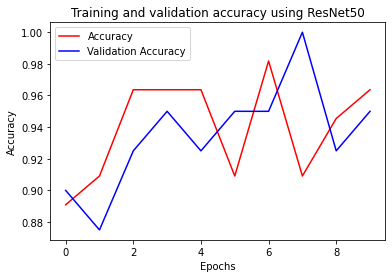

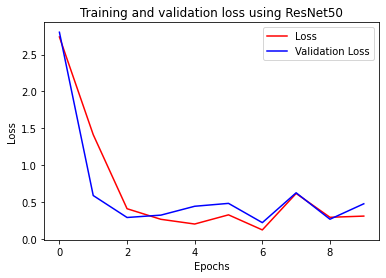

<Figure size 432x288 with 0 Axes>

In [0]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy using '+ptm)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss using '+ptm)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Github repository dataset related cells - not needed for Waterkant

In [0]:
#!pip install -q xlrd
#!git clone https://github.com/ieee8023/covid-chestxray-dataset
#TD Anstelle von dem oberen, dieses hier:
if not os.path.exists("covid-chestxray-dataset"):
    !git clone https://github.com/ieee8023/covid-chestxray-dataset covid-chestxray-dataset
else:
     !git -C covid-chestxray-dataset fetch --all
     !git -C covid-chestxray-dataset reset --hard origin/master

!ls covid-chestxray-dataset/

In [0]:
#TD Do not execute this if you do waterkand20 contest!!!

data_list = pd.read_csv('covid-chestxray-dataset/metadata.csv')

#Copy into source folders
data_dir = 'covid-chestxray-dataset/images'
rows = data_list.patientid 
n = len(rows)
for i in range(1,n):
#TD: Replaced by regex if data_list.loc[i, 'view'] == ('PA' or 'AP'): ... Now also accepting AP Suppinge, for example...
  if re.match(r"^PA|^AP",data_list.loc[i, 'view']):
    if data_list.loc[i, 'finding'] == ('COVID-19'): 
      FROM = os.path.join(data_dir, data_list.loc[i, 'filename'])
      TO = os.path.join(source_covid, data_list.loc[i, 'filename'])
#TD We monochromize the images and also specifically check for "hadcolor" and "nodpi". The files are saved as <name>_monochromized.tif
      copyfileMonochromized(FROM,TO)
#        copyfile(FROM,TO)    if data_list.loc[i, 'finding'] == ('No Finding'):
    if data_list.loc[i, 'finding'] == ('No Finding'):
      FROM = os.path.join(data_dir, data_list.loc[i, 'filename'])
      TO = os.path.join(source_nocovid, data_list.loc[i, 'filename'])
#TD We monochromize the images and also specifically check for "hadcolor" and "nodpi". The files are saved as <name>_monochromized.tif
      copyfileMonochromized(FROM,TO)
#        copyfile(FROM,TO)


In [0]:
#Define a dataset splitting function
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    source_list = os.listdir(SOURCE)
    for entry in source_list:
        if (os.path.exists(os.path.join(SOURCE, entry))):
            if (os.path.getsize((os.path.join(SOURCE,entry)) == 0)):
                print('% is zero length, so ignoring' %entry)
                source_list.remove(entry)
                
    source_list = random.sample(source_list, len(source_list))
    
    split_point = int(len(source_list) * SPLIT_SIZE)
    training_list = source_list[:split_point]
    testing_list = source_list[split_point:]

    for entry in training_list:
        FROM = os.path.join(SOURCE, entry)
        TO = os.path.join(TRAINING, entry)
        copyfile(FROM,TO)

    for entry in testing_list:
        FROM = os.path.join(SOURCE, entry)
        TO = os.path.join(TESTING, entry)
        print(FROM+"-->"+TO)
        copyfile(FROM,TO)


#Split the data into the representing sets in a certain ratio
#split_size = .6
#split_data(source_covid, training_covid_dir, testing_covid_dir, split_size)
#split_data(source_nocovid, training_nocovid_dir, testing_nocovid_dir, split_size)  

## KK
#print('training_covid: ', len(training_covid_dir), ' testing_covid: ', len(testing_covid_dir))
#print('training_nocovid: ', len(training_nocovid_dir), ' testing_nocovid: ', len(testing_nocovid_dir))

# Appendix

In [0]:
# Hyperparameters
lr=0.00001 # Learning rate # Adjusted by VD on 3.6.2020
dr=0.4 # Dropout rate
        
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(324, 324, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(dr),  
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(dr), \n",
        tf.keras.layers.Dense(1, activation='sigmoid') 
        ])
        
        
        
model.compile(optimizer=RMSprop(lr), loss='binary_crossentropy', metrics=['acc'])
      

SyntaxError: ignored

In [0]:


from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50


def vgg_1(shape_in):
    base_vgg_model = VGG16(include_top = True, input_shape = shape_in, weights ='imagenet')
    
    last_layer = base_vgg_model.layers[-2].output
    
    x = keras.layers.Dropout(0.2, name='dropout_1_0.2')(last_layer)
    x = keras.layers.Dense(1024, activation='relu', name='my_dense_1')(last_layer)
    x = keras.layers.Dropout(0.2, name='dropout_2_0.2')(x)
    x = keras.layers.Dense(256, activation='relu', name='my_dense_2')(x)
    x = keras.layers.Dropout(0.2, name='dropout_3_0.2')(x)
    my_output = keras.layers.Dense(3, activation='softmax', name='my_dense_3')(x)
    
    model = keras.models.Model(inputs=base_vgg_model.inputs, outputs=my_output, name='VGG16_1 ')
    
    for layer in base_vgg_model.layers[:-1]:
        layer.trainable = False
        
    model.summary()
     
    return model

  

def resnet(shape_in):
    base_resnet_model = ResNet50(include_top = True, input_shape = shape_in, weights ='imagenet')

    last_layer = base_resnet_model.layers[-2].output
    
    my_output = keras.layers.Dense(3, activation='softmax', name='my_dense')(last_layer)
    
    model = keras.models.Model(inputs=base_resnet_model.inputs, outputs=my_output, name='ResNet50 ')

    for layer in base_resnet_model.layers[:-1]:
        layer.trainable = False
    
    return model